<a href="https://colab.research.google.com/github/thu2912/HW6-Sta365/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [18]:

# 1) Choose "true" parameter values
mu_true = 0.0          # True location
sigma2_true = 1.0      # True scale^2
v_true = 5           # True degrees of freedom
n = 100                # Number of samples to generate

# 2) Generate n samples from a location-scale-t distribution
x = stats.t(df=v_true, loc=mu_true, scale=np.sqrt(sigma2_true)).rvs(size=n)

## --- 3. Initialize MCMC Parameters ---
C,G = 2,1000       # total number of samples
burn_in = 30         # discard first 30 as burn-in

sigma_0 = 1
tau_0 = 1
mu_0 = 0


# --- 4. Initialize MCMC Storage Arrays ---
mu_samples = np.zeros([C, G])      # Storage for mu across chains and iterations
sigma2_samples = np.zeros([C, G])  # Storage for sigma^2 across chains and iterations
v_samples = np.zeros([C, G])      # Storage for nu across chains and iterations


# Starting values for the Metropolis-within-Gibbs sampler
mu_samples[:, 0] = np.mean(x)      # Initial mu: sample mean
sigma2_samples[:,0] = np.var(x) # Initial sigma^2: sample variance
v_samples[:, 0]= 50                   # Initial nu (chosen arbitrarily from {1...100})

In [19]:
#5) target distributions:

sigma2_target = lambda sigma2_: np.prod(stats.t(df=v_true, loc=mu_true, scale=np.sqrt(sigma2_)).pdf(x)) * stats.halfnorm(scale=np.sqrt(sigma_0)).pdf(sigma2_)
mu_target = lambda mu_: np.prod(stats.t(df=v_true, loc=mu_, scale=np.sqrt(sigma2_true)).pdf(x)) * stats.norm(loc=mu_0, scale=1/np.sqrt(tau_0)).pdf(mu_)
v_target= lambda v_: np.prod(stats.t(df=v_, loc=mu_true, scale=np.sqrt(sigma2_true)).pdf(x)) * stats.uniform(loc=1, scale=100).pdf(v_)

for c in range(C):
    for g in range(1, G):
      ## Metropolis hasting on sigma2:
      # Independent proposal for sigma^2 (Half-Normal)
      sigma2_proposal = stats.halfnorm(scale=np.sqrt(1)).rvs()

    # Compute log acceptance probability
      sigma_log_alpha = np.log(sigma2_target(sigma2_proposal)) - \
                np.log(sigma2_target(sigma2_samples[c,g-1]))

    # Accept/reject step
      if np.log(np.random.uniform(0, 1)) < sigma_log_alpha:
        sigma2_samples[c,g] = sigma2_proposal  # Accept
      else:
        sigma2_samples[c,g] = sigma2_samples[c,g-1] # Reject

        ## Metropolis hasting on mu:
      # Independent proposal for mu (Nomal)
      mu_proposal = stats.norm(loc = mu_0, scale=1/ np.sqrt(tau_0)).rvs()

    # Compute log acceptance probability
      mu_log_alpha = np.log(mu_target(mu_proposal)) - \
                np.log(mu_target(mu_samples[c,g-1]))

    # Accept/reject step
      if np.log(np.random.uniform(0, 1)) < mu_log_alpha:
        mu_samples[c,g] = mu_proposal  # Accept
      else:
        mu_samples[c,g] = mu_samples[c,g-1] # Reject

         ## Metropolis hasting on vu:
      # Independent proposal for v
      v_proposal = stats.uniform(loc=1, scale=100).rvs()

    # Compute log acceptance probability
      v_log_alpha = np.log(v_target(v_proposal)) - \
                np.log(v_target(v_samples[c,g-1]))

    # Accept/reject step
      if np.log(np.random.uniform(0, 1)) < mu_log_alpha:
        v_samples[c,g] = v_proposal  # Accept
      else:
        v_samples[c,g] = v_samples[c,g-1] # Reject



<ipython-input-19-a074ed55ca8c>:14: RuntimeWarning: divide by zero encountered in log
  sigma_log_alpha = np.log(sigma2_target(sigma2_proposal)) - \


In [20]:
burnin = 20
for c in range(C):
  sigma2_pre = sigma2_samples[c,: burnin]
  mu_pre = mu_samples[c, :burnin]
  v_pre = v_samples[c, : burnin]

  sigma2_post = sigma2_samples[c, burnin:]
  mu_post = mu_samples[c, burnin:]
  v_post = v_samples[c, burnin:]

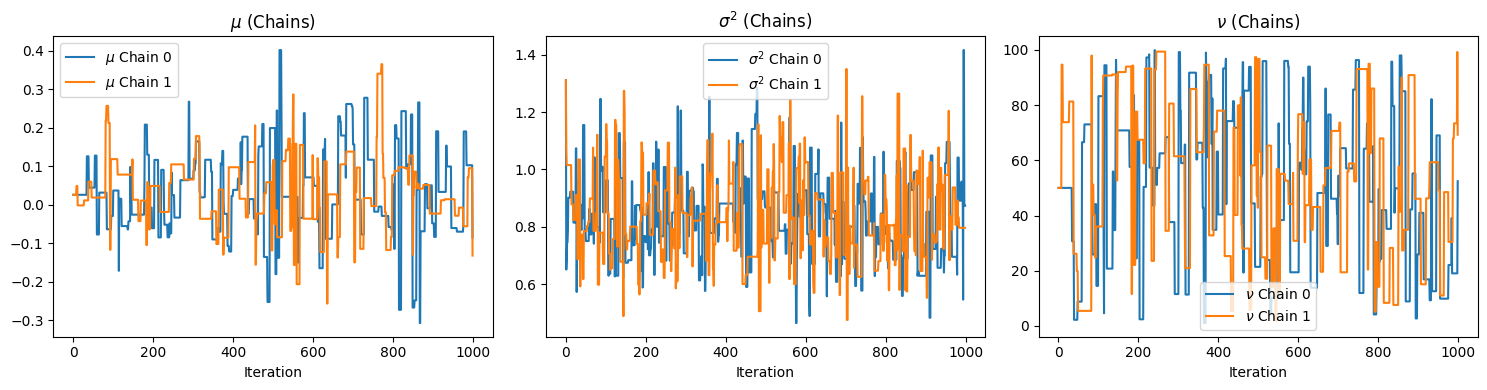

In [21]:
# --- MCMC Visualization ---
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].set_title(r"$\mu$ (Chains)")
ax[1].set_title(r"$\sigma^2$ (Chains)")
ax[2].set_title(r"$\nu$ (Chains)")

for c in range(C):
    ax[0].plot(np.arange(G), mu_samples[c, :], label=r"$\mu$ Chain "+str(c))
    ax[1].plot(np.arange(G), sigma2_samples[c, :], label=r"$\sigma^2$ Chain "+str(c))
    ax[2].plot(np.arange(G), v_samples[c, :], label=r"$\nu$ Chain "+str(c))

for a in ax:
    a.legend()
    a.set_xlabel("Iteration")

plt.tight_layout()
plt.show()

# Q2:

In [30]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [31]:
# --- True Parameters ---
mu_true = 0.0
sigma2_true = 1.0
nu_true = 50  # True degrees of freedom
n1 = 30
n2 = 10000
x_data1 = mu_true + sigma2_true * np.random.standard_t(nu_true, size=n1)
x_data2 = mu_true + sigma2_true * np.random.standard_t(nu_true, size=n2)



In [32]:
# --- PyMC Model ---
with pm.Model() as t_model1:
    # Priors
    mu = pm.Normal("mu", mu=0, sigma=1)  # Normal prior for mean
    sigma = pm.HalfNormal("sigma", sigma=1)  # Half-Normal prior for standard deviation
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Discrete uniform prior for degrees of freedom

    # Likelihood: Student-t distribution
    x_obs = pm.StudentT("x_obs", nu=nu, mu=mu, sigma=sigma, observed=x_data1)

In [33]:
m = 10000
with t_model1:
    idata1 = pm.sample(m, chains=2, tune=1000)

Output()

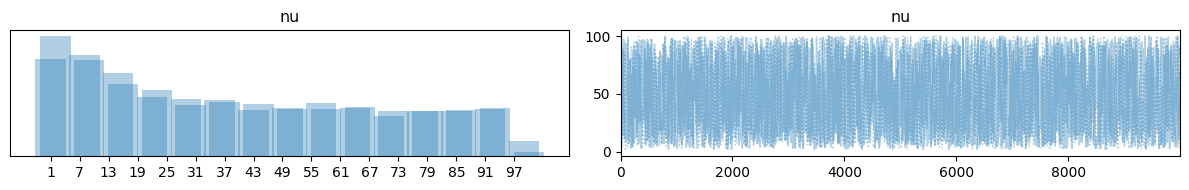

In [34]:
az.plot_trace(idata1.posterior['nu'])
plt.tight_layout()


In [35]:
az.summary(idata1.posterior['nu'], round_to=5, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,42.908,29.83053,2.0,94.0,0.61611,0.43571,1984.85503,1620.97496,1.00069


In [36]:
# --- PyMC Model ---
with pm.Model() as t_model2:
    # Priors
    mu = pm.Normal("mu", mu=0, sigma=1)  # Normal prior for mean
    sigma = pm.HalfNormal("sigma", sigma=1)  # Half-Normal prior for standard deviation
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Discrete uniform prior for degrees of freedom

    # Likelihood: Student-t distribution
    x_obs = pm.StudentT("x_obs", nu=nu, mu=mu, sigma=sigma, observed=x_data2)

In [37]:
with t_model2:
    idata2 = pm.sample(m, chains=2, tune=1000)

Output()

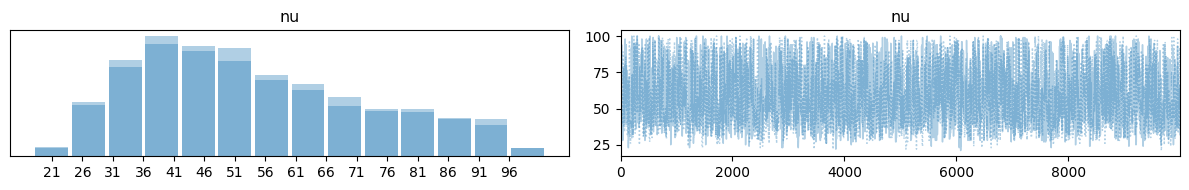

In [38]:
az.plot_trace(idata2.posterior['nu'])
plt.tight_layout()

In [39]:
az.summary(idata2.posterior['nu'], round_to=5, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,56.68265,18.86187,28.0,94.0,0.40444,0.28602,2123.92952,2872.23724,1.00011


(A) When n = 30:

Estimate for ν: Mean ~ 42.9

The 95% hdi is wider

(B) When m = 10000

Estimate for ν: Mean ~ 56.7 which is closer to the true v

The 95% hdi is smaller making v results more concise



## Q3

# ** Performing the Integral Step-by-Step**
We need to **integrate out $\tau_i$** from the joint distribution:

$$
p(y_i) = \int p(y_i \mid \tau_i) p(\tau_i) d\tau_i
$$

where:

### **1️ Likelihood: Normal Distribution**
The likelihood of $ y_i$ given $ \tau_i$ is:

$$
p(y_i \mid \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} \exp \left(-\frac{1}{2} \tau_i y_i^2 \right)
$$

### **2️ Prior: Gamma Distribution**
The prior on $\tau_i $ is:

$$
p(\tau_i) = \frac{\left( \frac{\nu}{2} \right)^{\frac{\nu}{2}}}{\Gamma \left( \frac{\nu}{2} \right)} \tau_i^{\frac{\nu}{2} - 1} \exp \left(-\frac{\nu}{2} \tau_i \right)
$$

Thus, we need to solve the following integral:

$$
p(y_i) = \int_0^\infty \left[ \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \right] \left[ \frac{\left( \frac{\nu}{2} \right)^{\frac{\nu}{2}}}{\Gamma \left( \frac{\nu}{2} \right)} \tau_i^{\frac{\nu}{2} - 1} e^{-\frac{\nu}{2} \tau_i} \right] d\tau_i
$$

---

## **  Terms**
Rewriting:

$$
p(y_i) = \frac{ \left( \frac{\nu}{2} \right)^{\frac{\nu}{2}} }{ \Gamma \left( \frac{\nu}{2} \right) } \sqrt{\frac{1}{2\pi}} \int_0^\infty \tau_i^{\frac{\nu}{2} - 1 + \frac{1}{2}} \exp \left[ -\left(\frac{\nu}{2} + \frac{y_i^2}{2} \right) \tau_i \right] d\tau_i
$$

$$
= \frac{ \left( \frac{\nu}{2} \right)^{\frac{\nu}{2}} }{ \Gamma \left( \frac{\nu}{2} \right) } \sqrt{\frac{1}{2\pi}} \int_0^\infty \tau_i^{\frac{\nu}{2} - \frac{1}{2}} \exp \left[ -\left(\frac{\nu}{2} + \frac{y_i^2}{2} \right) \tau_i \right] d\tau_i
$$

---

## **Recognizing a Gamma Integral**
We recognize that the integral follows the **Gamma integral identity**:

$$
\int_0^\infty x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}, \quad \text{for } a, b > 0
$$

Comparing terms, we identify:
- $a = \frac{\nu}{2} + \frac{1}{2} $
- $b = \frac{\nu}{2} + \frac{y_i^2}{2} $

Thus, solving the integral:

$$
\int_0^\infty \tau_i^{\frac{\nu}{2} - \frac{1}{2}} \exp \left[ -\left(\frac{\nu}{2} + \frac{y_i^2}{2} \right) \tau_i \right] d\tau_i
= \frac{\Gamma \left(\frac{\nu}{2} + \frac{1}{2} \right)}{\left(\frac{\nu}{2} + \frac{y_i^2}{2} \right)^{\frac{\nu}{2} + \frac{1}{2}}}
$$

---

## ** Final Expression**

Substituting back:

$$
p(y_i) = \frac{\left( \frac{\nu}{2} \right)^{\frac{\nu}{2}}}{\Gamma \left( \frac{\nu}{2} \right)} \sqrt{\frac{1}{2\pi}} \cdot \frac{\Gamma \left(\frac{\nu}{2} + \frac{1}{2} \right)}{\left(\frac{\nu}{2} + \frac{y_i^2}{2} \right)^{\frac{\nu}{2} + \frac{1}{2}}}
$$

Using the identity:

$$
\frac{\Gamma(a + \frac{1}{2})}{\Gamma(a)} = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})}
$$

and simplifying:

$$
p(y_i) = \frac{\Gamma \left(\frac{\nu+1}{2} \right)}{\Gamma \left(\frac{\nu}{2} \right) \sqrt{\nu \pi}} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$$

---

## **Recognizing the Final Distribution**
This is the **Student-\( t \) distribution**:

$$
y_i \sim t_{\nu} (0, 1)
$$

Thus, the posterior predictive distribution is:

$$
p(y_i) = \text{Student-}t \left( \nu \mid 0, 1 \right)
$$

# **Explaining the Analogy to the Posterior Predictive Distribution**
1. Posterior predictive distribution accounts for uncertainty: We integrate over $\tau_i$ to account for the uncertainty.
2. Heavy tail distribution: the student t distribution naturally arise from the product of $p(y_i| \tau_i)$ and $f(\tau_i)$. The uncertainty in the varience pull the distribution from Normal to a heavier tailed distribution. And using the monet generating function property of Gamma, we arrived at a t-distriution for marginal distribution of y